<a href="https://colab.research.google.com/github/Samin-Sadaf7/NN_works/blob/main/makemore_v3_mlp_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [2]:
# download the names.txt file from github
!wget https://raw.githubusercontent.com/karpathy/makemore/master/names.txt

--2024-07-06 04:10:03--  https://raw.githubusercontent.com/karpathy/makemore/master/names.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 228145 (223K) [text/plain]
Saving to: ‘names.txt’

names.txt           100%[===================>] 222.80K  --.-KB/s    in 0.04s   

2024-07-06 04:10:03 (5.85 MB/s) - ‘names.txt’ saved [228145/228145]



In [3]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [4]:
len(words)

32033

In [5]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [6]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):
  X, Y = [], []

  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [7]:
# MLP revisited
n_embd = 10
n_hidden = 200

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g)
b1 = torch.randn(n_hidden,                        generator=g)
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
b2 = torch.randn(vocab_size,                      generator=g) * 0

parameters = [C, W1, W2, b2]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

11697


In [8]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

  # forward pass
  emb = C[Xb] # embed the characters into vectors
  embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
  # Linear layer
  hpreact = embcat @ W1 #+ b1 # hidden layer pre-activation

  # -------------------------------------------------------------
  # Non-linearity
  h = torch.tanh(hpreact) # hidden layer
  logits = h @ W2 + b2 # output layer
  loss = F.cross_entropy(logits, Yb) # loss function

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  break

      0/ 200000: 3.3277


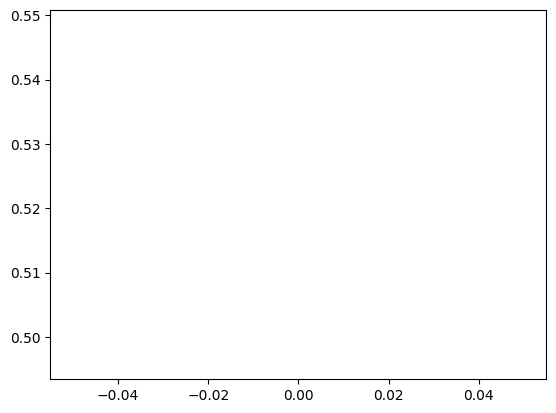

In [9]:
plt.plot(lossi)

We initialized the W1 to be very close to zero to get a lower loss initially. Because it will help the gradient move onto the toughest road to optimize the loss function. It will not go move to the smooth part. So there is no smoothly decreasing line in the graph.

In [10]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x]
  embcat = emb.view(emb.shape[0], -1)
  hpreact = embcat @ W1  + b1
  h = torch.tanh(hpreact) # (N, n_hidden)
  logits = h @ W2 + b2 # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 3.2052221298217773
val 3.204833745956421


**Problems** with value of **h** :
1. In the plot: the output of tanh is 1 or -1
2. While calculating gradient it becomes close to 0
3. So, it is not updating or decreasing the loss
4. If tanh=0, outgrad flows through no impact of tanh

(array([2069.,  145.,  101.,   73.,   68.,   48.,   42.,   44.,   32.,
          47.,   38.,   28.,   32.,   22.,   30.,   21.,   20.,   16.,
          15.,   14.,   23.,   27.,   14.,   20.,   23.,   29.,   25.,
          18.,   21.,   26.,   21.,   27.,   21.,   18.,   12.,   34.,
          32.,   21.,   28.,   31.,   35.,   23.,   50.,   35.,   47.,
          68.,   96.,  116.,  172., 2382.]),
 array([-1.  , -0.96, -0.92, -0.88, -0.84, -0.8 , -0.76, -0.72, -0.68,
        -0.64, -0.6 , -0.56, -0.52, -0.48, -0.44, -0.4 , -0.36, -0.32,
        -0.28, -0.24, -0.2 , -0.16, -0.12, -0.08, -0.04,  0.  ,  0.04,
         0.08,  0.12,  0.16,  0.2 ,  0.24,  0.28,  0.32,  0.36,  0.4 ,
         0.44,  0.48,  0.52,  0.56,  0.6 ,  0.64,  0.68,  0.72,  0.76,
         0.8 ,  0.84,  0.88,  0.92,  0.96,  1.  ]),
 <BarContainer object of 50 artists>)

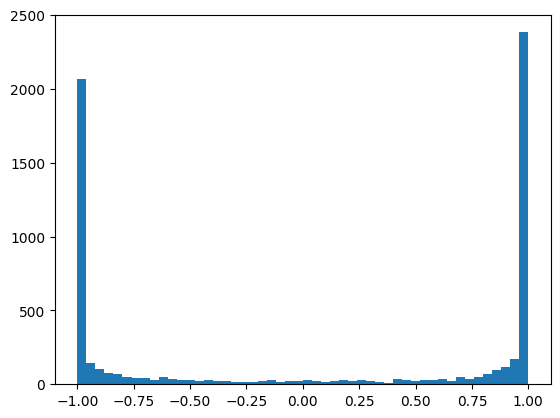

In [11]:
plt.hist(h.view(-1).tolist(),50)

(array([  1.,   2.,   0.,   1.,   5.,   3.,  11.,   6.,  13.,  10.,  25.,
         40.,  39.,  77.,  64.,  99., 134., 169., 187., 219., 224., 275.,
        308., 311., 355., 369., 379., 357., 366., 333., 292., 284., 287.,
        244., 187., 170., 134., 104.,  82.,  74.,  41.,  30.,  27.,  19.,
         12.,   7.,  12.,   3.,   2.,   7.]),
 array([-18.80574417, -18.08757278, -17.3694014 , -16.65123001,
        -15.93305862, -15.21488724, -14.49671585, -13.77854446,
        -13.06037308, -12.34220169, -11.6240303 , -10.90585892,
        -10.18768753,  -9.46951614,  -8.75134476,  -8.03317337,
         -7.31500198,  -6.5968306 ,  -5.87865921,  -5.16048782,
         -4.44231644,  -3.72414505,  -3.00597366,  -2.28780228,
         -1.56963089,  -0.8514595 ,  -0.13328812,   0.58488327,
          1.30305466,   2.02122604,   2.73939743,   3.45756882,
          4.1757402 ,   4.89391159,   5.61208298,   6.33025436,
          7.04842575,   7.76659714,   8.48476852,   9.20293991,
          9.921111

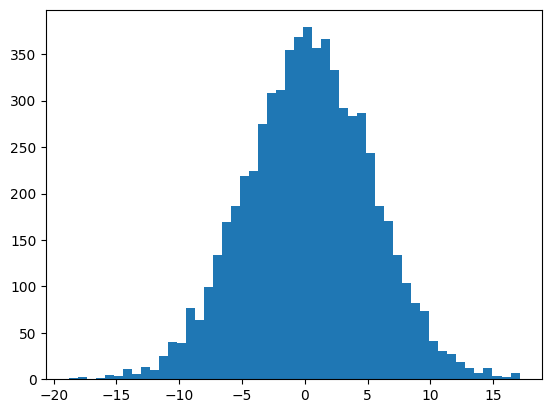

In [12]:
plt.hist(hpreact.view(-1).tolist(),50)

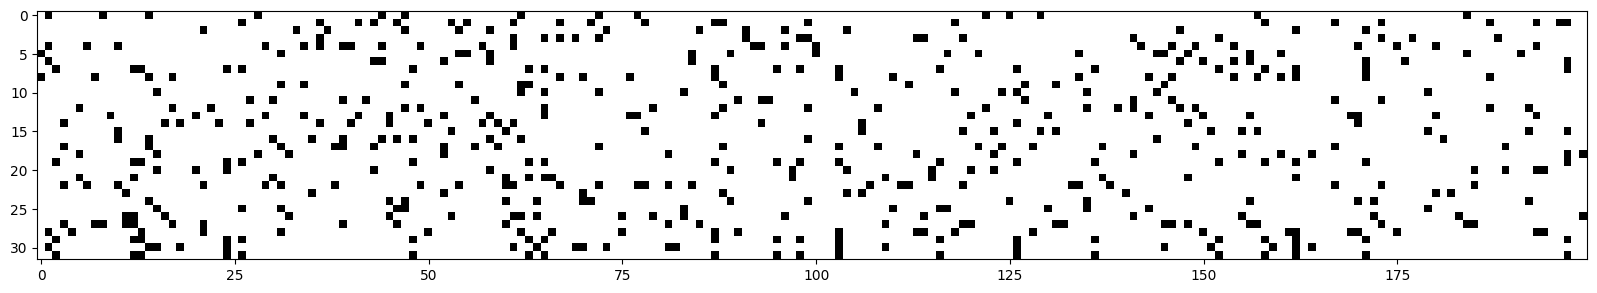

In [13]:
plt.figure(figsize=(20,10))
plt.imshow(h.abs()>0.5, cmap='gray', interpolation='nearest')

**To Solve** this issue we need h pre activation should be close to 0. It should not be too far off the 0.

In [14]:
# MLP revisited
n_embd = 10
n_hidden = 200

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * 0.2
b1 = torch.randn(n_hidden,                        generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
b2 = torch.randn(vocab_size,                      generator=g) * 0

parameters = [C, W1, W2, b2]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

11697


In [15]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

  # forward pass
  emb = C[Xb] # embed the characters into vectors
  embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
  # Linear layer
  hpreact = embcat @ W1 + b1 # hidden layer pre-activation

  # -------------------------------------------------------------
  # Non-linearity
  h = torch.tanh(hpreact) # hidden layer
  logits = h @ W2 + b2 # output layer
  loss = F.cross_entropy(logits, Yb) # loss function

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  #break

      0/ 200000: 3.3135
  10000/ 200000: 2.1715
  20000/ 200000: 2.3240
  30000/ 200000: 2.4010
  40000/ 200000: 1.9887
  50000/ 200000: 2.3029
  60000/ 200000: 2.4564
  70000/ 200000: 2.1249
  80000/ 200000: 2.3069
  90000/ 200000: 2.1057
 100000/ 200000: 1.8948
 110000/ 200000: 2.2326
 120000/ 200000: 1.9659
 130000/ 200000: 2.4410
 140000/ 200000: 2.2106
 150000/ 200000: 2.1795
 160000/ 200000: 1.8383
 170000/ 200000: 1.8131
 180000/ 200000: 1.9572
 190000/ 200000: 1.8002


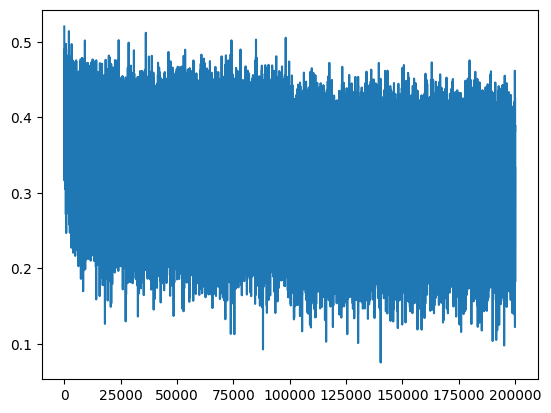

In [16]:
plt.plot(lossi)

In [17]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x]
  embcat = emb.view(emb.shape[0], -1)
  hpreact = embcat @ W1  + b1
  h = torch.tanh(hpreact) # (N, n_hidden)
  logits = h @ W2 + b2 # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.036555528640747
val 2.103057384490967


(array([ 885.,  251.,  166.,   97.,  114.,   79.,   87.,   85.,   63.,
          66.,   54.,   56.,   51.,   65.,   63.,   72.,   82.,   80.,
          65.,  103.,  133.,   94.,   93.,  107.,  158.,  119.,   80.,
          96.,  116.,   65.,   95.,   71.,   62.,   80.,   62.,   63.,
          88.,   67.,   51.,   46.,   66.,   60.,   77.,   93.,   96.,
         132.,  138.,  156.,  245., 1007.]),
 array([-1.00000000e+00, -9.60000002e-01, -9.20000005e-01, -8.80000007e-01,
        -8.40000010e-01, -8.00000012e-01, -7.60000014e-01, -7.20000017e-01,
        -6.80000019e-01, -6.40000021e-01, -6.00000024e-01, -5.60000026e-01,
        -5.20000029e-01, -4.80000031e-01, -4.40000033e-01, -4.00000036e-01,
        -3.60000038e-01, -3.20000041e-01, -2.80000043e-01, -2.40000045e-01,
        -2.00000048e-01, -1.60000050e-01, -1.20000052e-01, -8.00000548e-02,
        -4.00000572e-02, -5.96046448e-08,  3.99999380e-02,  7.99999356e-02,
         1.19999933e-01,  1.59999931e-01,  1.99999928e-01,  2.399999

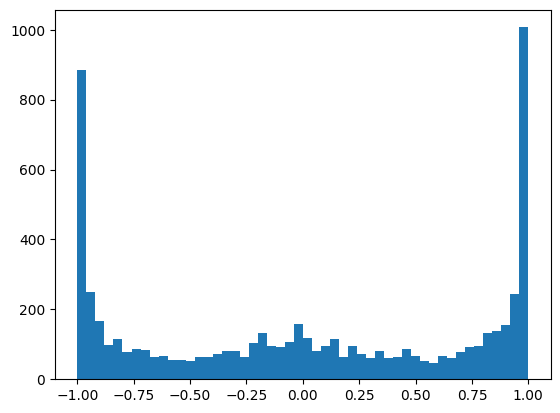

In [18]:
plt.hist(h.view(-1).tolist(),50)

(array([1.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 2.00e+00,
        1.00e+00, 2.00e+00, 5.00e+00, 2.00e+00, 5.00e+00, 7.00e+00,
        9.00e+00, 1.00e+01, 3.30e+01, 3.30e+01, 4.30e+01, 4.20e+01,
        6.80e+01, 8.30e+01, 1.22e+02, 1.43e+02, 1.68e+02, 2.27e+02,
        2.88e+02, 2.97e+02, 3.75e+02, 5.58e+02, 1.04e+03, 6.25e+02,
        3.64e+02, 3.91e+02, 2.90e+02, 2.50e+02, 2.08e+02, 1.61e+02,
        1.36e+02, 1.11e+02, 8.40e+01, 6.60e+01, 3.20e+01, 3.00e+01,
        3.30e+01, 2.00e+01, 1.30e+01, 5.00e+00, 8.00e+00, 4.00e+00,
        3.00e+00, 2.00e+00]),
 array([-11.0007267 , -10.61599222, -10.23125774,  -9.84652327,
         -9.46178879,  -9.07705431,  -8.69231983,  -8.30758535,
         -7.92285088,  -7.5381164 ,  -7.15338192,  -6.76864744,
         -6.38391296,  -5.99917849,  -5.61444401,  -5.22970953,
         -4.84497505,  -4.46024057,  -4.0755061 ,  -3.69077162,
         -3.30603714,  -2.92130266,  -2.53656818,  -2.15183371,
         -1.76709923,  -1.38236475,  -0.99

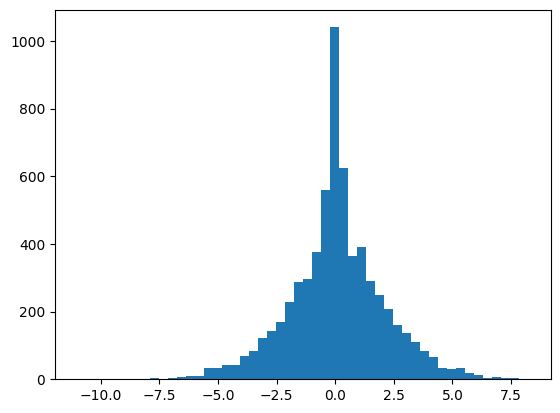

In [19]:
plt.hist(hpreact.view(-1).tolist(),50)

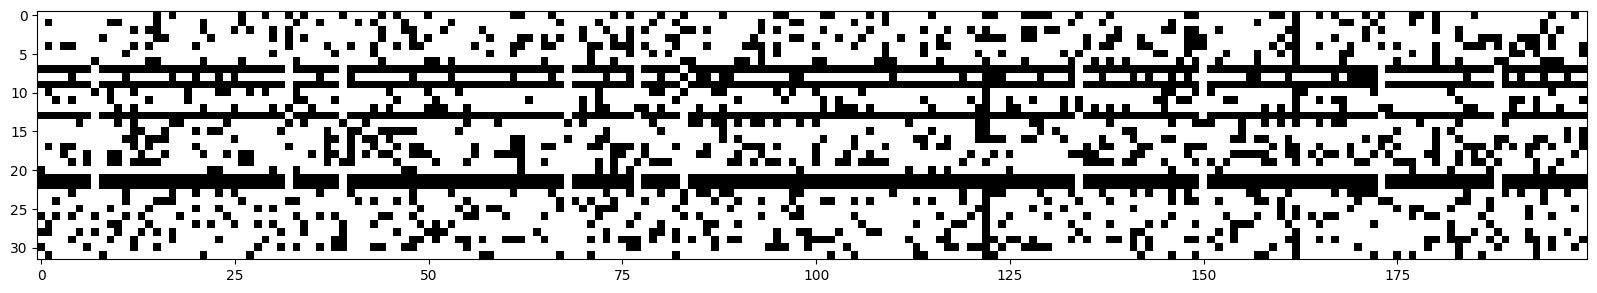

In [20]:
plt.figure(figsize=(20,10))
plt.imshow(h.abs()>0.5, cmap='gray', interpolation='nearest')

Calculating the initial scale.
1. Divide by the square root of fan in
2. if the standard deviation is higher than the x, we have the y spread out largely.
3. If the standard deviation is smaller, it does not spread

tensor(0.0063) tensor(0.9848)
tensor(0.0069) tensor(0.8728)


(array([3.01271120e-04, 0.00000000e+00, 6.02542239e-04, 9.03813359e-04,
        1.80762672e-03, 1.50635560e-03, 2.10889784e-03, 7.53177799e-03,
        1.23521159e-02, 1.71724538e-02, 2.74156719e-02, 3.58512632e-02,
        5.75427839e-02, 7.59203222e-02, 1.03637265e-01, 1.34969462e-01,
        1.80762672e-01, 2.32581304e-01, 2.77470701e-01, 3.47365601e-01,
        3.97677878e-01, 4.52207951e-01, 4.99808788e-01, 4.74803285e-01,
        4.68777862e-01, 4.36843124e-01, 3.75986357e-01, 3.22962640e-01,
        2.66926212e-01, 2.18421562e-01, 1.68711827e-01, 1.22617346e-01,
        1.00925825e-01, 6.53758330e-02, 4.36843124e-02, 3.19347387e-02,
        1.59673693e-02, 1.86788094e-02, 9.64067583e-03, 6.02542239e-03,
        3.01271120e-03, 1.80762672e-03, 2.10889784e-03, 3.01271120e-04,
        9.03813359e-04, 3.01271120e-04, 0.00000000e+00, 6.02542239e-04,
        3.01271120e-04, 3.01271120e-04]),
 array([-3.86516809, -3.69920463, -3.53324116, -3.36727769, -3.20131422,
        -3.03535075, 

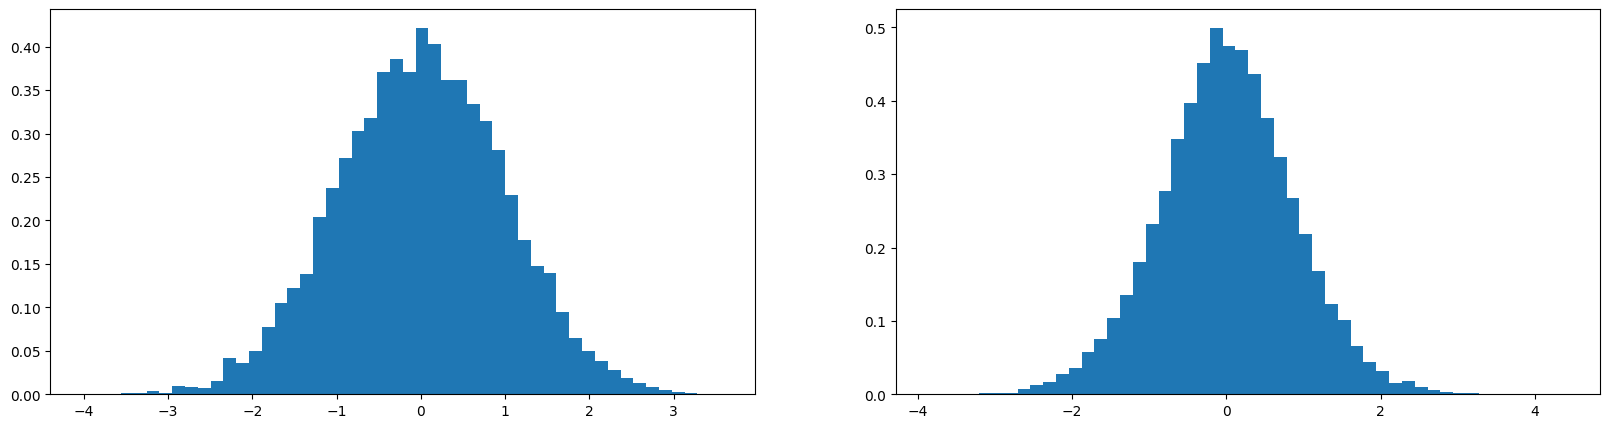

In [21]:
x= torch.randn(1000, 10)
w= torch.randn(10, 20) / (10 ** 0.5) # fan in is 10, the dimension which does not stay in the y but a criteria to multiply
y = x @ w
print(x.mean(), x.std())
print(y.mean(), y.std())
plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
plt.hist(x.view(-1).tolist(),50, density = True)
plt.subplot(1,2,2)
plt.hist(y.view(-1).tolist(),50, density = True)

Kaiming initialization paper suggests a gain for the activation function and how to initialize to get the best training situation.

In [22]:
#For tanh gain is 5/3
(5/3)/(30 ** 0.5)

0.3042903097250923

In [23]:
# MLP revisited
n_embd = 10
n_hidden = 200

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd*block_size) ** 0.5)
b1 = torch.randn(n_hidden,                        generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
b2 = torch.randn(vocab_size,                      generator=g) * 0

parameters = [C, W1, W2, b2]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

11697


In [24]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

  # forward pass
  emb = C[Xb] # embed the characters into vectors
  embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
  # Linear layer
  hpreact = embcat @ W1 + b1 # hidden layer pre-activation

  # -------------------------------------------------------------
  # Non-linearity
  h = torch.tanh(hpreact) # hidden layer
  logits = h @ W2 + b2 # output layer
  loss = F.cross_entropy(logits, Yb) # loss function

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  #break

      0/ 200000: 3.3179
  10000/ 200000: 2.1928
  20000/ 200000: 2.3333
  30000/ 200000: 2.5376
  40000/ 200000: 1.9618
  50000/ 200000: 2.3344
  60000/ 200000: 2.3849
  70000/ 200000: 2.1605
  80000/ 200000: 2.3181
  90000/ 200000: 2.2200
 100000/ 200000: 1.8285
 110000/ 200000: 2.1300
 120000/ 200000: 1.9468
 130000/ 200000: 2.3329
 140000/ 200000: 2.1031
 150000/ 200000: 2.1707
 160000/ 200000: 1.7700
 170000/ 200000: 1.7840
 180000/ 200000: 1.9529
 190000/ 200000: 1.8062


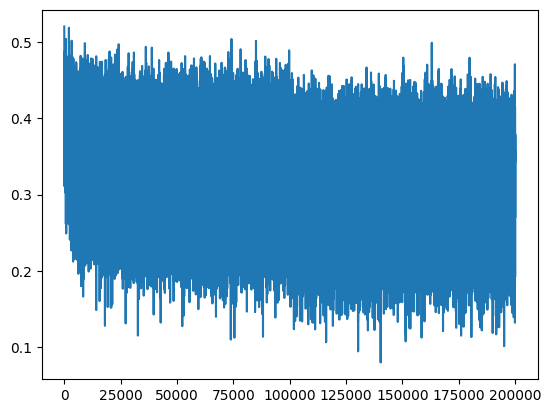

In [25]:
plt.plot(lossi)

In [26]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x]
  embcat = emb.view(emb.shape[0], -1)
  hpreact = embcat @ W1  + b1
  h = torch.tanh(hpreact) # (N, n_hidden)
  logits = h @ W2 + b2 # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.0394740104675293
val 2.109386444091797


(array([1076.,  211.,  170.,  107.,   99.,   79.,   74.,   52.,   86.,
          50.,   65.,   49.,   53.,   67.,   49.,   69.,   84.,  110.,
          58.,   93.,   73.,   63.,   95.,   78.,  111.,   79.,  129.,
          87.,   95.,   85.,   62.,   72.,   73.,   74.,   68.,   60.,
          69.,   67.,   65.,   68.,   60.,   79.,   91.,   67.,  107.,
          95.,  130.,  167.,  238., 1092.]),
 array([-1.  , -0.96, -0.92, -0.88, -0.84, -0.8 , -0.76, -0.72, -0.68,
        -0.64, -0.6 , -0.56, -0.52, -0.48, -0.44, -0.4 , -0.36, -0.32,
        -0.28, -0.24, -0.2 , -0.16, -0.12, -0.08, -0.04,  0.  ,  0.04,
         0.08,  0.12,  0.16,  0.2 ,  0.24,  0.28,  0.32,  0.36,  0.4 ,
         0.44,  0.48,  0.52,  0.56,  0.6 ,  0.64,  0.68,  0.72,  0.76,
         0.8 ,  0.84,  0.88,  0.92,  0.96,  1.  ]),
 <BarContainer object of 50 artists>)

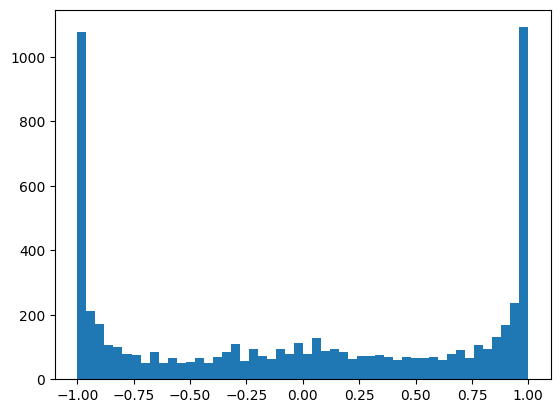

In [27]:
plt.hist(h.view(-1).tolist(),50)

(array([  1.,   2.,   0.,   1.,   3.,   5.,   8.,   7.,  13.,  24.,  27.,
         37.,  56.,  56.,  91., 107., 135., 180., 189., 204., 268., 307.,
        345., 545., 877., 599., 427., 343., 316., 243., 213., 174., 126.,
        109.,  88.,  73.,  44.,  48.,  34.,  23.,  21.,  12.,   7.,   3.,
          3.,   1.,   1.,   2.,   1.,   1.]),
 array([-9.66356754, -9.2710623 , -8.87855705, -8.48605181, -8.09354656,
        -7.70104132, -7.30853607, -6.91603083, -6.52352558, -6.13102034,
        -5.73851509, -5.34600985, -4.9535046 , -4.56099936, -4.16849411,
        -3.77598886, -3.38348362, -2.99097837, -2.59847313, -2.20596788,
        -1.81346264, -1.42095739, -1.02845215, -0.6359469 , -0.24344166,
         0.14906359,  0.54156883,  0.93407408,  1.32657932,  1.71908457,
         2.11158981,  2.50409506,  2.8966003 ,  3.28910555,  3.68161079,
         4.07411604,  4.46662128,  4.85912653,  5.25163177,  5.64413702,
         6.03664227,  6.42914751,  6.82165276,  7.214158  ,  7.60666325,
 

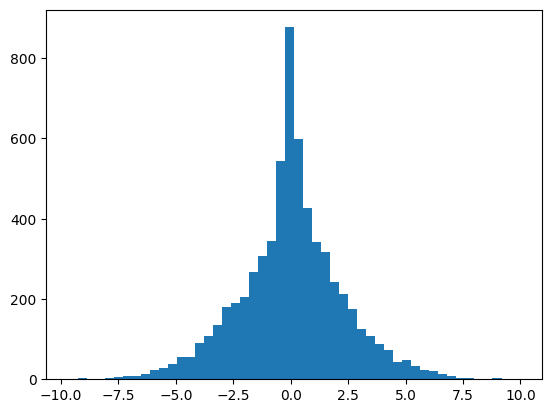

In [28]:
plt.hist(hpreact.view(-1).tolist(),50)

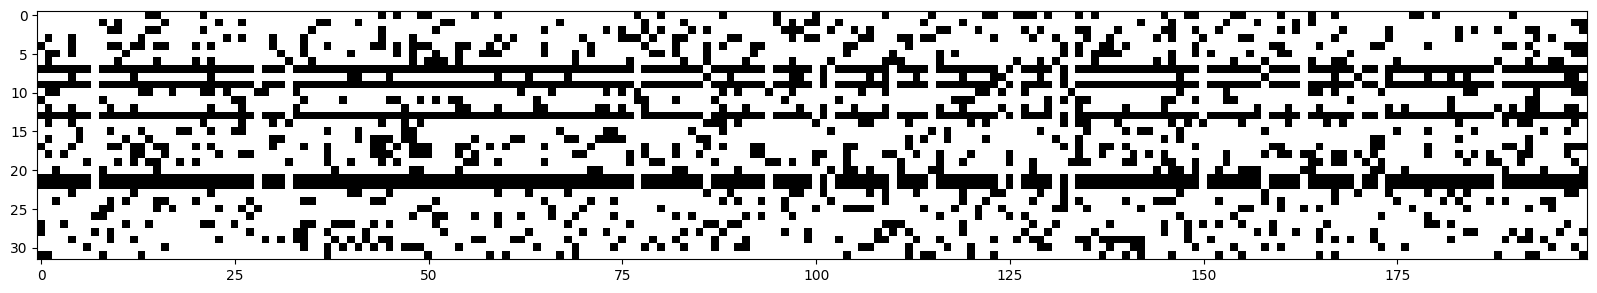

In [29]:
plt.figure(figsize=(20,10))
plt.imshow(h.abs()>0.5, cmap='gray', interpolation='nearest')

**Batch Normalization**
Normalizing batch can help the initialization to be normal.Not just roughly normal. It can help training greatly. But additionally, we need to add some normalization gain. Otherwise, every time h preactivation will be set to normal. We want it to move around and gradient to tell us where the graph should be shifted.



*   Batch Normalization makes some of the batch examples normal which looks like a bug. Cause problem is we are coupling some samples and make them normal which is mathematically problematic.
*   Weirdly, this is good. Because it works as regularizer which helps the model not to overfit on training set. So, we can not discard it.



In [30]:
hpreact.shape

torch.Size([32, 200])

In [31]:
hpreact.mean(0, keepdim=True).shape

torch.Size([1, 200])

In [32]:
hpreact.std(0, keepdim=True).shape

torch.Size([1, 200])

In [33]:
# MLP revisited
n_embd = 10
n_hidden = 200

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd*block_size) ** 0.5)
b1 = torch.randn(n_hidden,                        generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
b2 = torch.randn(vocab_size,                      generator=g) * 0

bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden)) #for batch normalization for gain and bias
parameters = [C, W1, W2, b2, bngain,bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

12097


In [34]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

  # forward pass
  emb = C[Xb] # embed the characters into vectors
  embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
  # Linear layer
  hpreact = embcat @ W1 + b1 # hidden layer pre-activation
  hpreact = hpreact - hpreact.mean(0, keepdim=True)
  hpreact = hpreact / hpreact.std(0, keepdim=True)
  hpreact = bngain * hpreact + bnbias
  # -------------------------------------------------------------
  # Non-linearity
  h = torch.tanh(hpreact) # hidden layer
  logits = h @ W2 + b2 # output layer
  loss = F.cross_entropy(logits, Yb) # loss function

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())

      0/ 200000: 3.3147
  10000/ 200000: 2.1984
  20000/ 200000: 2.3375
  30000/ 200000: 2.4359
  40000/ 200000: 2.0119
  50000/ 200000: 2.2595
  60000/ 200000: 2.4775
  70000/ 200000: 2.1020
  80000/ 200000: 2.2788
  90000/ 200000: 2.1862
 100000/ 200000: 1.9474
 110000/ 200000: 2.3010
 120000/ 200000: 1.9837
 130000/ 200000: 2.4523
 140000/ 200000: 2.3839
 150000/ 200000: 2.1987
 160000/ 200000: 1.9733
 170000/ 200000: 1.8668
 180000/ 200000: 1.9973
 190000/ 200000: 1.8347


Problem during test time: The neural net now wants batch size to normalize the batches. In the test set, we give individual data to the model and get an output for it. That does not seem to be possible right here. So, we calculate mean of batch gain and bias for that and use that in the training set.

In [35]:
with torch.no_grad():
  emb = C[Xtr]
  embcat = emb.view(emb.shape[0], -1)
  hpreact = embcat @ W1 + b1
#calculate the mean and std for the whole training set
  bnmean = hpreact.mean(0, keepdim=True)
  bnstd = hpreact.std(0, keepdim=True)

In [41]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x]
  embcat = emb.view(emb.shape[0], -1)
  hpreact = embcat @ W1 + b1 # hidden layer pre-activation
  hpreact = bngain * ((hpreact-bnmean)/bnstd) + bnbias
  h = torch.tanh(hpreact) # (N, n_hidden)
  logits = h @ W2 + b2 # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.0668270587921143
val 2.104926824569702


Let's introduce running mean and standard deviation and not putting an extra layer of code after a certain training completion. We just want to go straight to test

In [37]:
# MLP revisited
n_embd = 10
n_hidden = 200

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd*block_size) ** 0.5)
b1 = torch.randn(n_hidden,                        generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
b2 = torch.randn(vocab_size,                      generator=g) * 0

bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden)) #for batch normalization for gain and bias
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))
parameters = [C, W1, W2, b2, bngain,bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

12097


In [38]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

  # forward pass
  emb = C[Xb] # embed the characters into vectors
  embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
  # Linear layer
  hpreact = embcat @ W1 + b1 # hidden layer pre-activation
  bnmean_i = hpreact.mean(0, keepdim=True)
  bnstd_i = hpreact.std(0, keepdim=True)
  hpreact = bngain * ((hpreact-bnmean_i)/bnstd_i) + bnbias

  with torch.no_grad():
    bnmean_running = 0.999 * bnmean_running + 0.001 * bnmean_i
    bnstd_running = 0.999 * bnstd_running + 0.001 * bnstd_i
  # -------------------------------------------------------------
  # Non-linearity
  h = torch.tanh(hpreact) # hidden layer
  logits = h @ W2 + b2 # output layer
  loss = F.cross_entropy(logits, Yb) # loss function

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())

      0/ 200000: 3.3147
  10000/ 200000: 2.1984
  20000/ 200000: 2.3375
  30000/ 200000: 2.4359
  40000/ 200000: 2.0119
  50000/ 200000: 2.2595
  60000/ 200000: 2.4775
  70000/ 200000: 2.1020
  80000/ 200000: 2.2788
  90000/ 200000: 2.1862
 100000/ 200000: 1.9474
 110000/ 200000: 2.3010
 120000/ 200000: 1.9837
 130000/ 200000: 2.4523
 140000/ 200000: 2.3839
 150000/ 200000: 2.1987
 160000/ 200000: 1.9733
 170000/ 200000: 1.8668
 180000/ 200000: 1.9973
 190000/ 200000: 1.8347


In [40]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x]
  embcat = emb.view(emb.shape[0], -1)
  hpreact = embcat @ W1 + b1 # hidden layer pre-activation
  hpreact = bngain * ((hpreact-bnmean_running)/bnstd_running) + bnbias
  h = torch.tanh(hpreact) # (N, n_hidden)
  logits = h @ W2 + b2 # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.06659197807312
val 2.1050572395324707
